<a href="https://colab.research.google.com/github/Tokelo22/My-Package/blob/master/Copy_of_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDSA: Sendy Logistics Challenge

##Introduction

---



In this project we are assisting Sendy with the challenge of creating a model that will assist in predicting the estimated time of arrival of the delivery of orders, from the point of driver pickup to the point of arrival at final destination. In which our model will help Sendy enhance customer communication and improve the reliability of its service, to improve customer experience, also to help reduce the cost of the business, through improved resource management.

##Import Libraries

---



In [267]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb


##Import datasets

---



In [268]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
riders = pd.read_csv('Riders.csv')
samplesubmission = pd.read_csv('SampleSubmission.csv')

##Exploratory Data Analysis

---



In [269]:
train.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


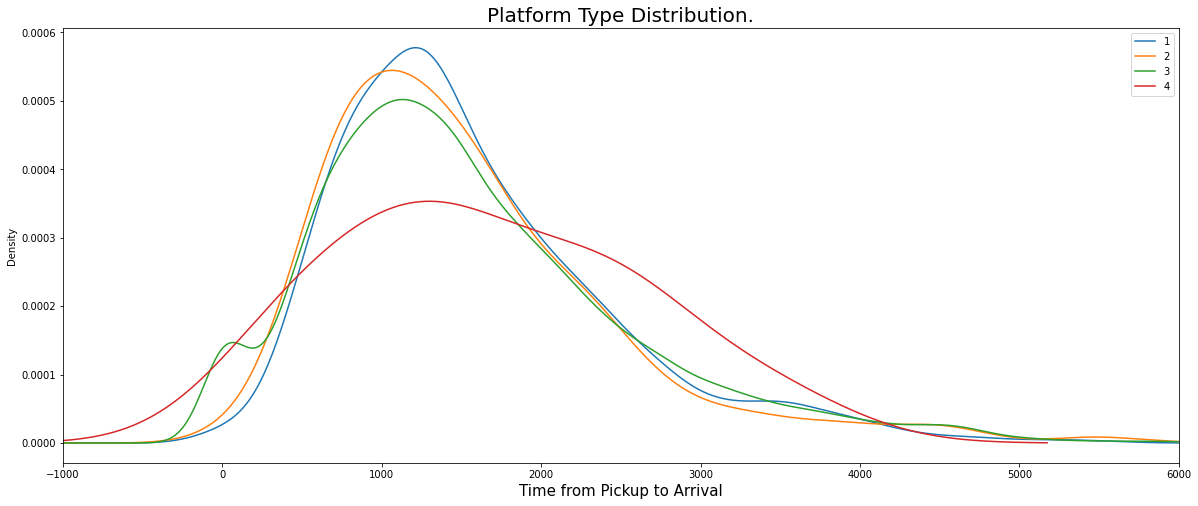

In [270]:
train.groupby('Platform Type')['Time from Pickup to Arrival'].plot(kind='kde', figsize=[20,8], legend=True)
plt.xlim([-1000,6000.0])
plt.xlabel('Time from Pickup to Arrival',fontsize=15)
plt.title('Platform Type Distribution.',fontsize=20)
plt.show()

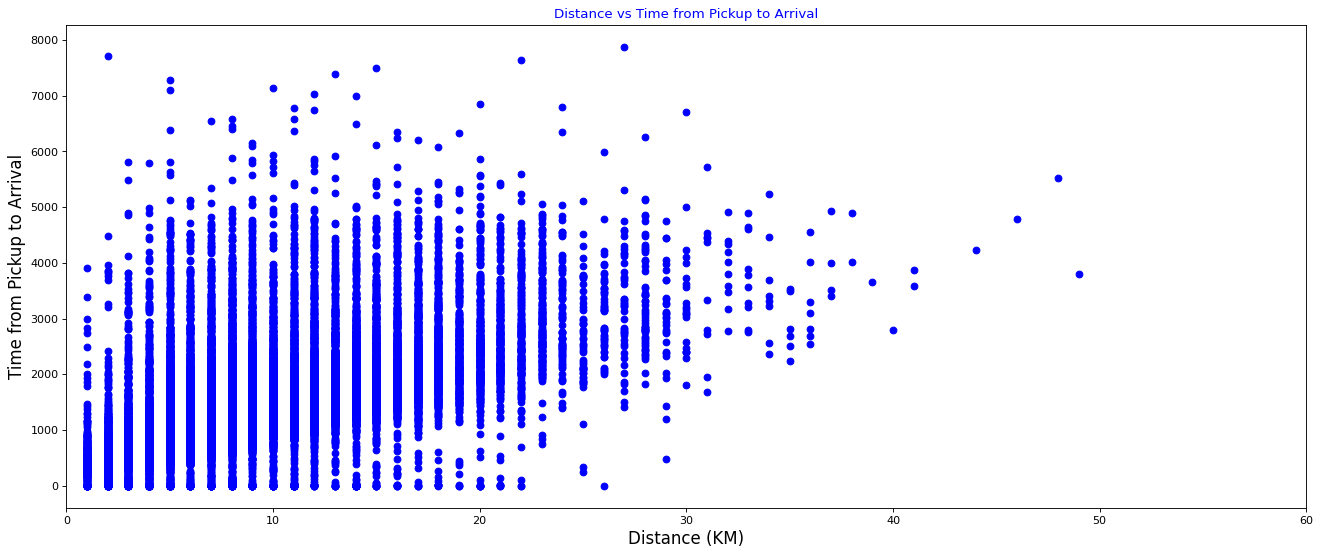

In [271]:

X = train["Distance (KM)"]
y = train["Time from Pickup to Arrival"]

plt.figure(figsize=(20, 8), dpi=80)
plt.scatter(X, y, color='blue')
plt.title("Distance vs Time from Pickup to Arrival",color='blue')
plt.xlabel("Distance (KM)",fontsize=15)
plt.ylabel("Time from Pickup to Arrival",fontsize=15)
ax.plot(y_test,y_test,'r')
plt.xlim([0,60])
plt.show()


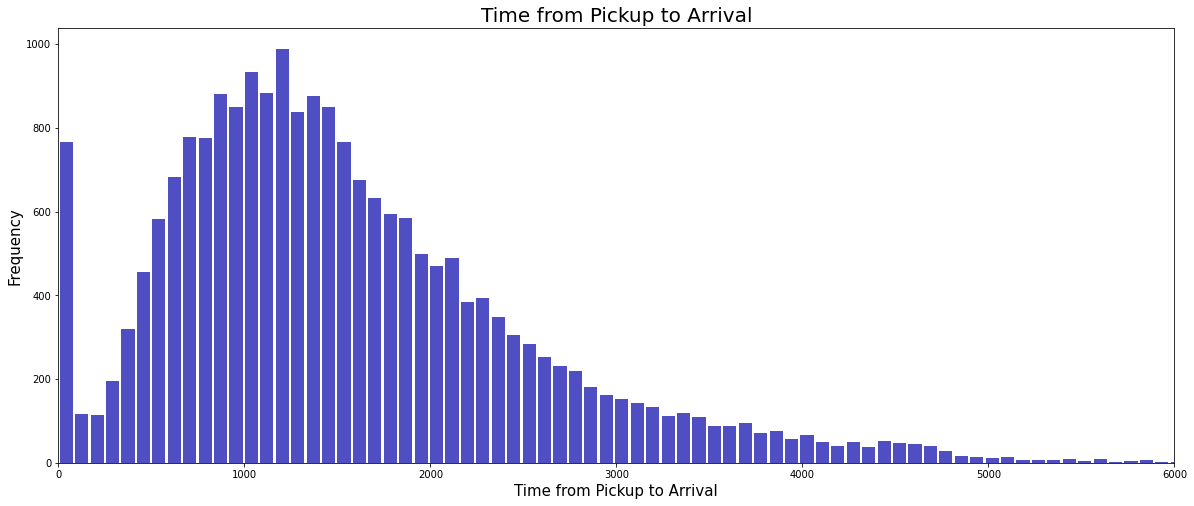

In [272]:
#fig, ax = plt.subplots()
train.hist(column='Time from Pickup to Arrival', figsize=(20,8), grid=False, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel("Time from Pickup to Arrival",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Time from Pickup to Arrival",fontsize=20)
plt.xlim([0.0,6000.0])
plt.show()

In [273]:
train = train[(train['Time from Pickup to Arrival'] > 60)]
train = train[(train['Distance (KM)'] <= 40)]
train

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21195,Order_No_9932,User_Id_3582,Bike,3,Business,2,6,1:08:34 PM,2,6,1:25:40 PM,2,6,1:52:11 PM,2,6,1:54:36 PM,2,6,2:33:21 PM,17,29.0,NaN,-1.238406,36.871870,-1.276549,36.766981,Rider_Id_34,2325
21197,Order_No_22892,User_Id_1796,Bike,3,Business,13,6,10:13:34 AM,13,6,10:13:41 AM,13,6,10:20:04 AM,13,6,10:33:27 AM,13,6,10:46:17 AM,7,26.0,NaN,-1.307143,36.825009,-1.331619,36.847976,Rider_Id_155,770
21198,Order_No_2831,User_Id_2956,Bike,3,Business,7,4,5:06:16 PM,7,4,5:07:09 PM,7,4,5:30:17 PM,7,4,5:50:52 PM,7,4,6:40:05 PM,20,29.2,NaN,-1.286018,36.897534,-1.258414,36.804800,Rider_Id_697,2953
21199,Order_No_6174,User_Id_2524,Bike,1,Personal,4,3,9:31:39 AM,4,3,9:31:53 AM,4,3,9:38:59 AM,4,3,9:45:15 AM,4,3,10:08:15 AM,13,15.0,NaN,-1.250030,36.874167,-1.279209,36.794872,Rider_Id_347,1380


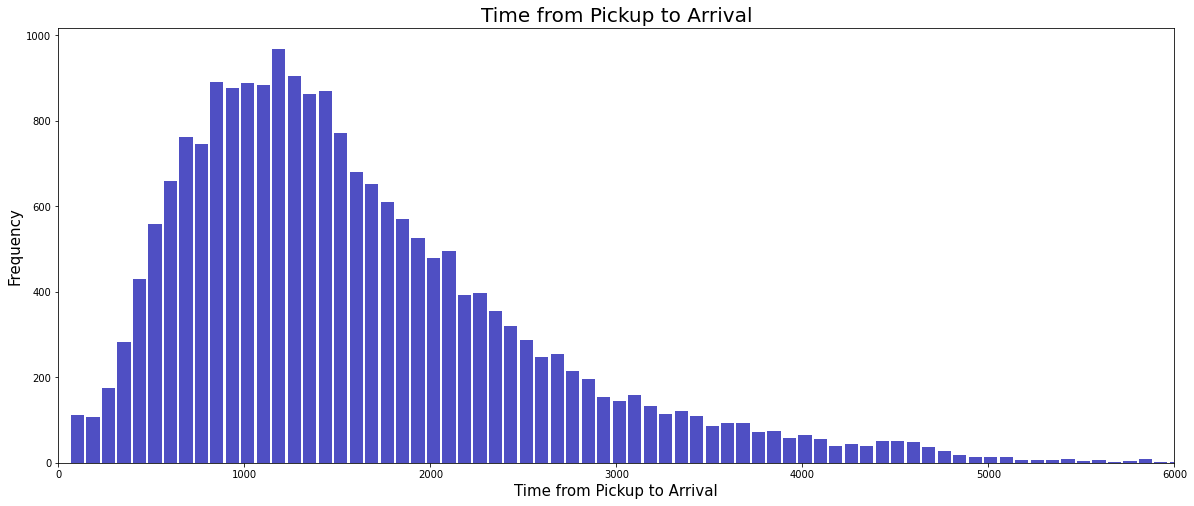

In [274]:
train.hist(column='Time from Pickup to Arrival', figsize=(20,8), grid=False, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel("Time from Pickup to Arrival",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Time from Pickup to Arrival",fontsize=20)
plt.xlim([0,6000.0])
plt.show()

In [275]:
test.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [276]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20455 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   20455 non-null  object 
 1   User Id                                    20455 non-null  object 
 2   Vehicle Type                               20455 non-null  object 
 3   Platform Type                              20455 non-null  int64  
 4   Personal or Business                       20455 non-null  object 
 5   Placement - Day of Month                   20455 non-null  int64  
 6   Placement - Weekday (Mo = 1)               20455 non-null  int64  
 7   Placement - Time                           20455 non-null  object 
 8   Confirmation - Day of Month                20455 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            20455 non-null  int64  
 10  Confirmation - Time   

Convert time to datetime format.

In [277]:
train['Placement - Time'] =  (pd.to_timedelta(train['Placement - Time']).astype(int)/60)
train['Confirmation - Time'] =  (pd.to_timedelta(train['Confirmation - Time']).astype(int)/60)
train['Arrival at Pickup - Time'] =  pd.to_timedelta(train['Arrival at Pickup - Time']).astype(int)/60
train['Arrival at Destination - Time'] =  pd.to_timedelta(train['Arrival at Destination - Time']).astype(int)/60
train['Pickup - Time'] =  pd.to_timedelta(train['Pickup - Time']).astype(int)/60

test['Placement - Time'] =  pd.to_timedelta(test['Placement - Time']).astype(int)/60
test['Confirmation - Time'] =  pd.to_timedelta(test['Confirmation - Time']).astype(int)/60
test['Arrival at Pickup - Time'] =  pd.to_timedelta(test['Arrival at Pickup - Time']).astype(int)/60
test['Pickup - Time'] =  pd.to_timedelta(test['Pickup - Time']).astype(int)/60

From the above table we see that precipitation only has less than 3% of the values  in the table, hence we are removing it from our data.
Removed the Vehichle type since it is the same vehicle in this instance a bike.
While for the missing values in Temperature we replace them with the average/mean of the number in the Temperature column.

In [278]:
train.drop('Precipitation in millimeters', axis=1, inplace=True)
train.drop('Vehicle Type', axis=1, inplace=True)
train.drop('Order No', axis=1, inplace=True)   #Comment the text
train.drop('Arrival at Destination - Day of Month', axis=1, inplace=True)   #Comment the text
train.drop('Arrival at Destination - Weekday (Mo = 1)', axis=1, inplace=True)   #Comment the text
train.drop('Arrival at Destination - Time', axis=1, inplace=True)   #Comment the text
train.drop('User Id', axis=1, inplace=True)   #Comment the text
train.drop('Temperature', axis=1, inplace=True)   #Comment the text
train.drop('Rider Id', axis=1, inplace=True)   #Comment the text
test.drop('Precipitation in millimeters', axis=1, inplace=True)
test.drop('Vehicle Type', axis=1, inplace=True)
test.drop('Order No', axis=1, inplace=True)    #Comment the text
test.drop('Temperature', axis=1, inplace=True)   #Comment the text
test.drop('User Id', axis=1, inplace=True)    #Comment the text
test.drop('Rider Id', axis=1, inplace=True)    #Comment the text

train = train.fillna(train.mean())
test = test.fillna(train.mean())

In [279]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20455 entries, 0 to 21200
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Platform Type                         20455 non-null  int64  
 1   Personal or Business                  20455 non-null  object 
 2   Placement - Day of Month              20455 non-null  int64  
 3   Placement - Weekday (Mo = 1)          20455 non-null  int64  
 4   Placement - Time                      20455 non-null  float64
 5   Confirmation - Day of Month           20455 non-null  int64  
 6   Confirmation - Weekday (Mo = 1)       20455 non-null  int64  
 7   Confirmation - Time                   20455 non-null  float64
 8   Arrival at Pickup - Day of Month      20455 non-null  int64  
 9   Arrival at Pickup - Weekday (Mo = 1)  20455 non-null  int64  
 10  Arrival at Pickup - Time              20455 non-null  float64
 11  Pickup - Day of

Encoding the data for 'Personal or Business' column into dummy variables.

In [280]:
train['Personal or Business'] = pd.get_dummies(train['Personal or Business'])
test['Personal or Business'] = pd.get_dummies(test['Personal or Business'])

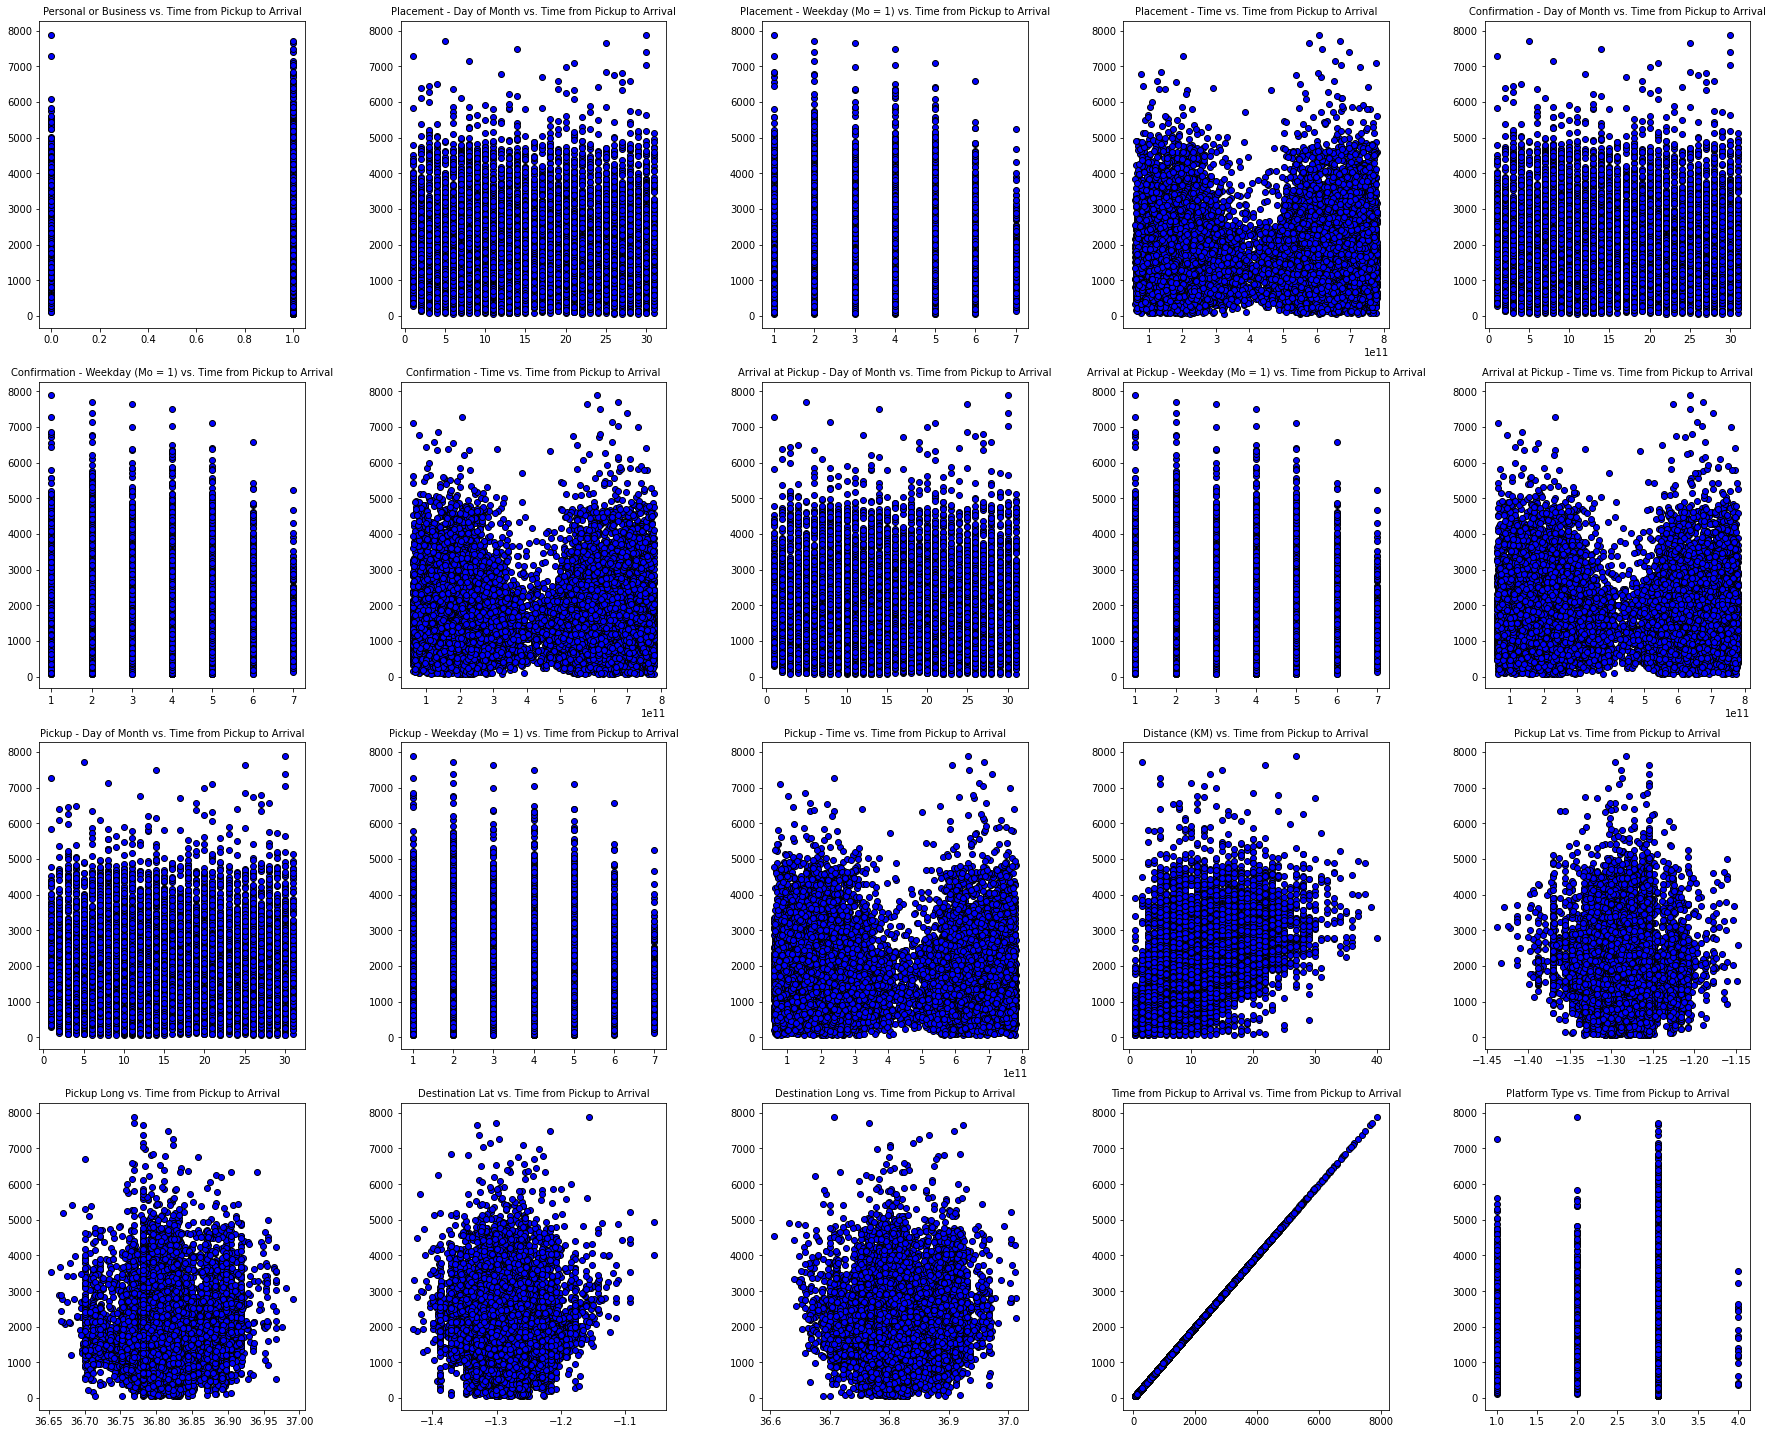

In [281]:
fig, axs = plt.subplots(4,5, figsize=(25,20))
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()

for index, column in enumerate(train.columns):
    axs[index-1].set_title("{} vs. Time from Pickup to Arrival".format(column),fontsize=10)
    axs[index-1].scatter(x=train[column],y=train['Time from Pickup to Arrival'],color='blue',edgecolor='k')

fig.tight_layout(pad=1)

The 5 Number Summary.

In [282]:
train.describe().round(2)

,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
count,20455.00,20455.00,20455.00,20455.00,2.045500e+04,20455.00,20455.00,2.045500e+04,20455.00,20455.00,2.045500e+04,20455.00,20455.00,2.045500e+04,20455.00,20455.00,20455.00,20455.00,20455.00,20455.00
mean,2.74,0.81,15.64,3.24,4.353894e+11,15.64,3.24,4.310905e+11,15.64,3.24,4.244599e+11,15.64,3.24,4.188489e+11,9.61,-1.28,36.81,-1.28,36.81,1612.08
std,0.63,0.39,8.79,1.57,2.450887e+11,8.79,1.57,2.449880e+11,8.79,1.57,2.454119e+11,8.79,1.57,2.455549e+11,5.64,0.03,0.04,0.03,0.04,958.27
min,1.00,0.00,1.00,1.00,6.001667e+10,1.00,1.00,6.000000e+10,1.00,1.00,6.005000e+10,1.00,1.00,6.000000e+10,1.00,-1.44,36.65,-1.43,36.61,62.00
25%,3.00,1.00,8.00,2.00,1.863167e+11,8.00,2.00,1.872250e+11,8.00,2.00,1.873083e+11,8.00,2.00,1.876417e+11,5.00,-1.30,36.78,-1.30,36.79,929.00
50%,3.00,1.00,15.00,3.00,5.275667e+11,15.00,3.00,5.163000e+11,15.00,3.00,4.347000e+11,15.00,3.00,3.509000e+11,8.00,-1.28,36.81,-1.28,36.81,1405.00
75%,3.00,1.00,23.00,5.00,6.630083e+11,23.00,5.00,6.621500e+11,23.00,5.00,6.616917e+11,23.00,5.00,6.628250e+11,13.00,-1.26,36.83,-1.26,36.83,2071.00
max,4.00,1.00,31.00,7.00,7.799833e+11,31.00,7.00,7.799667e+11,31.00,7.00,7.799667e+11,31.00,7.00,7.799833e+11,40.00,-1.15,36.99,-1.05,37.01,7883.00


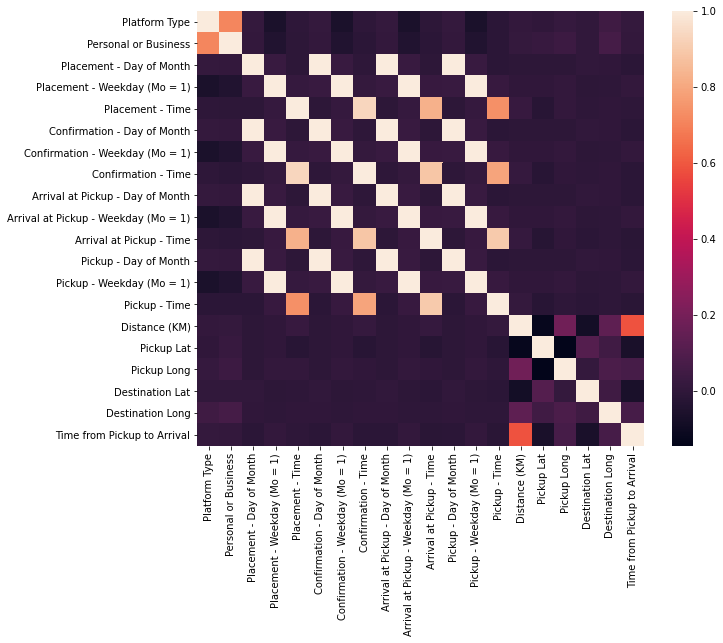

In [283]:
plt.figure(figsize=(10,8))
corr = train.corr()
sns.heatmap(corr)

##Data Preprocess

In [284]:
X = train.iloc[:,:-1].values    #Assign x values 
y = train.iloc[:,-1].values     #Assign y values 


In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)  #Split the data to test and train

##Modelling

###Model 1 - Multiple Linear Regression

Linear regression performs the task to predict a dependent variable value (y) based on more than two variables given independent variables (x's). So, this regression technique finds out a linear relationship between x values (input) and y(output).

In [286]:
mlm = LinearRegression()
mlm.fit(X_train,y_train)

y_pred_mlm = mlm.predict(X_test)

training_rmse_mlm = np.sqrt(mse(y,mlm.predict(X)))
validation_rmse_mlm = np.sqrt(mse(y_test,y_pred_mlm))

In [287]:
print(training_rmse_mlm)
print(validation_rmse_mlm)

775.589929770167
776.3194602274685


###Model 2 - Decision  Tree

Decision trees are predictive models that uses a flow chart like tree structure to predict the output on the basis of input or situation described by a set of properties. 

In [288]:
dtr = DecisionTreeRegressor(max_depth=7, random_state=42)
dtr.fit(X_train,y_train)

y_pred_dtr = dtr.predict(X_test)

training_rmse_dtr = np.sqrt(mse(y,dtr.predict(X)))
validation_rmse_dtr = np.sqrt(mse(y_test,y_pred_dtr))

In [289]:
print(training_rmse_dtr)
print(validation_rmse_dtr)

748.5347598018014
795.9542554212256


###Model 3 - Random Forest

A Random Forest is an ensemble technique that makes use of multiple decision trees and a technique called Bootstrap Aggregation, The trees in random forests are ran parallel. There is no interaction between these trees while building the trees.

In [290]:
rfr = RandomForestRegressor(random_state=23)
rfr.fit(X_train,y_train)

y_pred_rfr = rfr.predict(X_test)

training_rmse_rfr = np.sqrt(mse(y,rfr.predict(X)))
validation_rmse_rfr = np.sqrt(mse(y_test,y_pred_rfr))

In [291]:
print(training_rmse_rfr)
print(validation_rmse_rfr )

431.10495949617643
771.8645994805936


*Random Forest Adjusted*

In [292]:
rfr_3 = RandomForestRegressor(n_estimators=110, max_depth=7, random_state=23,min_samples_split=6,n_jobs=1)
rfr_3.fit(X_train,y_train)

y_pred_rfr_3 = rfr_3.predict(X_test)

training_rmse_rfr_3 = np.sqrt(mse(y,rfr_3.predict(X)))
validation_rmse_rfr_3 = np.sqrt(mse(y_test,y_pred_rfr_3))

In [293]:
print(training_rmse_rfr_3)
print(validation_rmse_rfr_3)

732.8987876248295
761.9899067683866


###Model 4 - Gradient Boost Regression

Gradient Boosting Regressors(GBR) are ensemble decision tree regressor models, which produces a prediction models.

In [294]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.4, max_depth=1, random_state=23)
gbr.fit(X_train,y_train)

y_pred_gbr = gbr.predict(X_test)

training_rmse_gbr = np.sqrt(mse(y,gbr.predict(X)))
validation_rmse_gbr = np.sqrt(mse(y_test,y_pred_gbr))

In [295]:
print(training_rmse_gbr)
print(validation_rmse_gbr)

760.4398846564179
764.3830971235132


###Model 5 - Stacking Regression

Stacking regressions is a method for forming linear combinations of different predictors to give improved prediction accuracy.

In [296]:
models = [("RF2",rfr_2),("RF3",rfr_3)]

meta_learner_reg = LinearRegression()
s_reg = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)
s_reg.fit(X_train,y_train)

y_pred_s_reg = s_reg.predict(X_test)

training_rmse_s_reg = np.sqrt(mse(y,s_reg.predict(X)))
validation_rmse_s_reg = np.sqrt(mse(y_test,y_pred_s_reg))

In [297]:
print(training_rmse_s_reg)
print(validation_rmse_s_reg)

688.2761505566913
760.4003018617661


###Model 6 - XG Boost Regression

XGBoost is a decision-tree-based ensemble in Machine Learning algorithm that uses a gradient boosting framework.

In [298]:
xgb_model = xgb.XGBRegressor(random_state=42,learning_rate=0.,n_estimators=100,gamma=0,colsample_bytree=0.5)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

training_rmse = np.sqrt(mse(y,xgb_model.predict(X)))
validation_rmse = np.sqrt(mse(y_test,y_pred))

[16:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [299]:
print(training_rmse_xgb)
print(validation_rmse_xgb)

730.4641352374734
753.3636669999702


In [309]:
models = [("DT",dtr),("RT",rfr_3),("GB",gbr),("XG",s_reg)]

meta_learner_reg = LinearRegression()
s_reg3 = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)
s_reg3.fit(X_train,y_train)

y_pred_s_reg3 = s_reg3.predict(X_test)

training_rmse_s_reg3 = np.sqrt(mse(y,s_reg3.predict(X)))
validation_rmse_s_reg3 = np.sqrt(mse(y_test,y_pred_s_reg3))

In [310]:
print(training_rmse_s_reg3)
print(validation_rmse_s_reg3)

677.628328024713
757.5601915032134


##Best Model (Stacking Regression)



In [302]:
models = [("XB",xgb_model),("RT",rfr_3)]

meta_learner_reg = LinearRegression()
s_reg3 = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)
s_reg3.fit(X_train,y_train)

y_pred_s_reg3 = s_reg3.predict(X_test)

training_rmse_s_reg3 = np.sqrt(mse(y,s_reg3.predict(X)))
validation_rmse_s_reg3 = np.sqrt(mse(y_test,y_pred_s_reg3))

[16:49:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:49:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [303]:
print(training_rmse_s_reg3)
print(validation_rmse_s_reg3)

732.7627655975673
762.0393666972507


##Testing

In [304]:
samplesubmission.head()

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,567.0
1,Order_No_12736,4903.0
2,Order_No_768,5649.0
3,Order_No_15332,NaN
4,Order_No_21373,NaN


In [313]:
samplesubmission['Time from Pickup to Arrival'] = s_reg3.predict(test.values)

In [316]:
samplesubmission.to_csv('tk28.csv',index=False)

In [317]:
pd.read_csv('tk28.csv').head()

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,1653.774414
1,Order_No_12736,1470.264929
2,Order_No_768,1181.943557
3,Order_No_15332,1039.347378
4,Order_No_21373,1112.050454


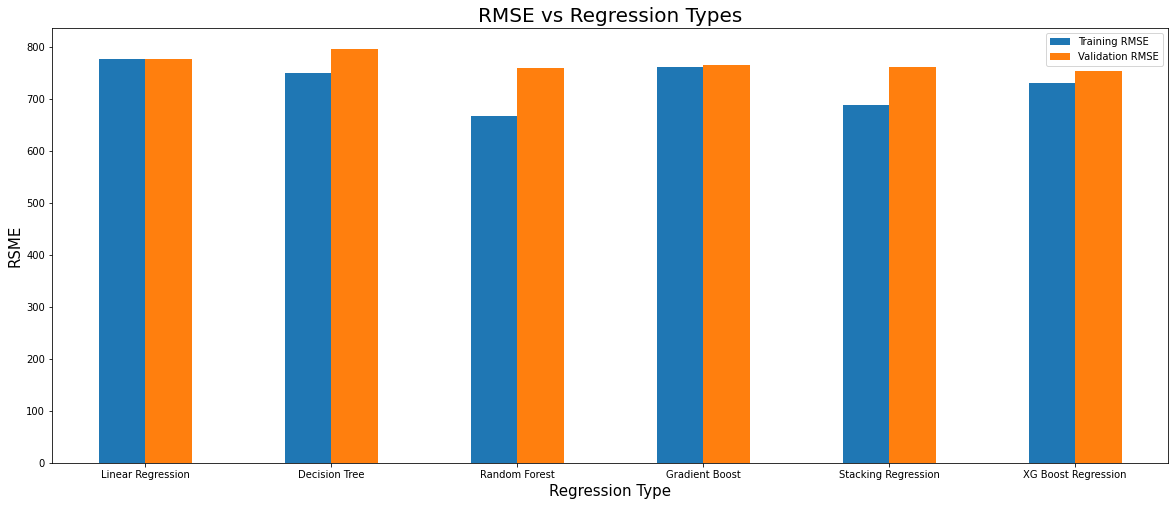

In [308]:
training_rmse = [training_rmse_mlm, training_rmse_dtr, training_rmse_rfr_2, training_rmse_gbr, training_rmse_s_reg, training_rmse_xgb]
validation_rmse = [validation_rmse_mlm, validation_rmse_dtr, validation_rmse_rfr_2, validation_rmse_gbr, validation_rmse_s_reg, validation_rmse_xgb]
index = ['Linear Regression', 'Decision Tree', 'Random Forest',
         'Gradient Boost', 'Stacking Regression', 'XG Boost Regression']
df = pd.DataFrame({'Training RMSE': training_rmse,
                   'Validation RMSE': validation_rmse}, index=index)
ax = df.plot.bar(rot=0, figsize=(20,8))
plt.title("RMSE vs Regression Types",fontsize=20)
plt.xlabel("Regression Type",fontsize=15)
plt.ylabel("RSME",fontsize=15)
plt.show()